<a href="https://colab.research.google.com/github/FilippoAiraldi/RL-demos/blob/main/lunar_lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lunar Lander

In [1]:
!pip install -qq Box2D

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

from multiprocessing import Pool, cpu_count

from tqdm.notebook import tqdm

## Visualization

In [3]:
def do_all_plots(ep_lengths, ep_rewards, title = None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    if title: fig.suptitle(title)
    ax1.plot(ep_lengths, color='C0')
    ax1.set_xlabel('episode (#)')
    ax1.set_ylabel('steps (#)')
    ax1.set_title('episode length')
    ax2.plot(ep_rewards, color='C1')
    ax2.set_xlabel('episode (#)')
    ax2.set_ylabel('reward (#)')
    ax2.set_title('episode total reward')

## RBF function approximation

In [7]:
def Q_learning_with_rbf_linapprox(env, gamma = 0.99, episodes = 2000):
    obs_space, act_space = env.observation_space.shape, env.action_space.n

    # create random observations
    obs_samples = np.stack([env.observation_space.sample() for x in range(5000)])

    # fit a scaler (removes mean and std)
    scaler = StandardScaler()
    scaler.fit(obs_samples)

    # fit a rbf feature mapper
    gammas = [5, 2, 1, 0.5] 
    rbf_mapper = FeatureUnion([(f'rbf{i}', RBFSampler(gamma=g)) for i, g in enumerate(gammas)])
    rbf_mapper.fit(obs_samples)

    # preprocess from env state to new features
    preprocess = lambda s: rbf_mapper.transform(scaler.transform(s.reshape(1, -1)))

    # create a Q linear SGD function for each action
    Q_fncs = []
    for a in range(act_space):
        mdl = SGDRegressor(learning_rate='constant')
        mdl.partial_fit(preprocess(np.zeros(obs_space)), [0])
        Q_fncs.append(mdl)

    # compute Q(s, a) or Q(s, :)
    get_Q = lambda s, a: Q_fncs[a].predict(preprocess(s))
    get_Qs = lambda s: np.asarray([Q_fncs[a].predict(preprocess(s)) for a in range(act_space)])
    
    # perform an SGD update step for Q(s, a)
    update_Q = lambda s, a, target: Q_fncs[a].partial_fit(preprocess(s), [target]) 

    # get best action with exploration
    policy = lambda s, eps: get_Qs(s).argmax() if np.random.rand() > eps else env.action_space.sample()

    # training loop
    ep_lengths, tot_rewards, smoothed_lengths, smoothed_rewards = [], [], [], []
    for ep in tqdm(range(episodes)):
        # reset env and compute epsilon for this episode
        epsilon = 0.9 * 0.997**ep
        steps, tot_reward = 0, 0
        state, done = env.reset(), False

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            target = reward + gamma * get_Qs(next_state).max()
            update_Q(state, action, target)
            
            tot_reward += reward
            steps += 1
            if steps > 500: break # if it gets stuck
            state = next_state
    
        ep_lengths.append(steps)
        smoothed_lengths.append(np.mean(ep_lengths[min(0, ep - 200):]))
        tot_rewards.append(tot_reward)
        smoothed_rewards.append(np.mean(tot_rewards[min(0, ep - 200):]))
        if ep % (episodes // 20) == 0:
            print(f'episode {ep}: mean steps = {smoothed_lengths[-1]:3f}, total mean reward = {smoothed_rewards[-1]:.3f}')

    # deterministic policy
    policy = lambda s: get_Qs(s).argmax()
    # softmax policy 
    # ...

    return policy, smoothed_lengths, smoothed_rewards

  0%|          | 0/2000 [00:00<?, ?it/s]

episode 0: mean steps = 86.0, total mean reward = -320.135
episode 100: mean steps = 114.99, total mean reward = -140.612
episode 200: mean steps = 130.54726368159203, total mean reward = -118.237
episode 300: mean steps = 169.59800664451828, total mean reward = -103.313
episode 400: mean steps = 207.8054862842893, total mean reward = -89.306
episode 500: mean steps = 249.28542914171658, total mean reward = -72.213
episode 600: mean steps = 282.20465890183027, total mean reward = -57.083
episode 700: mean steps = 307.96005706134093, total mean reward = -43.485
episode 800: mean steps = 331.86392009987514, total mean reward = -31.013
episode 900: mean steps = 349.30632630410656, total mean reward = -21.253
episode 1000: mean steps = 360.5214785214785, total mean reward = -8.571
episode 1100: mean steps = 363.91734786557674, total mean reward = 3.361
episode 1200: mean steps = 370.02664446294756, total mean reward = 13.701
episode 1300: mean steps = 372.5196003074558, total mean reward =

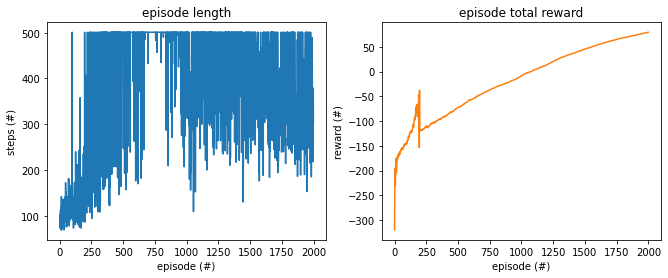

In [8]:
env = gym.make('LunarLander-v2')
policy, ep_lengths, ep_total_rewards = Q_learning_with_rbf_linapprox(env)
do_all_plots(ep_lengths, ep_total_rewards)

## Testing

In [11]:
def test(original_env, policy, episodes = 10, render=False):
    if render:
        !apt -qq install xvfb
        !pip install -qq gym-notebook-wrapper
        import gnwrapper
    
    ep_lengths = []
    ep_total_rewards = []
    
    # run episodes
    for ep in tqdm(range(episodes)):
        env = gnwrapper.Monitor(original_env) if render else original_env

        # run till done
        steps, tot_reward, done = 0, 0, False
        state = env.reset()
        while not done:
            action = policy(state)
            state, reward, done, _ = env.step(action)
            steps += 1
            tot_reward += reward

        # append results
        ep_lengths.append(steps)
        ep_total_rewards.append(tot_reward)

        # show episode
        print(f'episode {ep}: steps = {steps}, total reward = {tot_reward:.3f}')
        if render:
            env.display()
    return ep_lengths, ep_total_rewards

The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Selecting previously unselected package xvfb.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


  0%|          | 0/10 [00:00<?, ?it/s]

episode 0: steps = 450, total reward = 236.335


'openaigym.video.0.1911.video000000.mp4'

episode 1: steps = 347, total reward = 253.370


'openaigym.video.1.1911.video000000.mp4'

episode 2: steps = 1000, total reward = -52.801


'openaigym.video.2.1911.video000000.mp4'

episode 3: steps = 329, total reward = 206.507


'openaigym.video.3.1911.video000000.mp4'

episode 4: steps = 334, total reward = 239.056


'openaigym.video.4.1911.video000000.mp4'

episode 5: steps = 594, total reward = 152.395


'openaigym.video.5.1911.video000000.mp4'

episode 6: steps = 449, total reward = 247.370


'openaigym.video.6.1911.video000000.mp4'

episode 7: steps = 667, total reward = 120.743


'openaigym.video.7.1911.video000000.mp4'

episode 8: steps = 900, total reward = 84.809


'openaigym.video.8.1911.video000000.mp4'

episode 9: steps = 407, total reward = 259.841


'openaigym.video.9.1911.video000000.mp4'

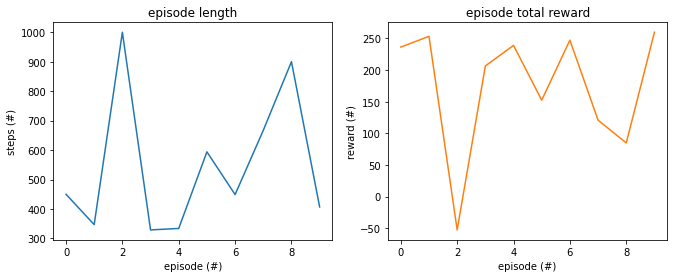

In [15]:
!rm -rf 202*/

env = gym.make('LunarLander-v2')
ep_lengths, ep_total_rewards = test(env, policy, episodes = 10, render=True)

do_all_plots(ep_lengths, ep_total_rewards)